In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


In [4]:
# Data processing and model train

from libs.ml import AtmosphericalData
from tensorflow import keras
from keras.src.callbacks import EarlyStopping
from keras.regularizers import l2
def train_model(target_column:str, date_col: str, train_column: str, n_steps:int, training_args: dict, model_args: list, compile_args: dict = None):
    ## Read data and preprocessing

    inside = []
    for v in model_args:
        layer = getattr(keras.layers, v['layer'])

        inside.append(layer(v['units'], **v['args']))

    model = keras.models.Sequential(inside)

    ad = AtmosphericalData(model=model, path=f"./data/{target_column}/{target_column}_decomposition.csv", use_cudnn=False)
    del model

    print(ad.df.columns)

    ad.convert_date(date_col=date_col)
    ad.target_selection(train_column)
    ad.data_preprocessing(n_steps=n_steps, train_vol=0.9)

    ## Train data
    ad.train_data(
        epochs=training_args['epochs'],
        batch_size=training_args['batch_size'],
        validation_split=training_args['validation_split'],
        verbose=training_args['verbose'],
        **compile_args
    )


    ## Test trained model
    ad.test_model()


    ## Plot comparison
    ad.plot_tests()

    return ad

In [6]:
target = 'aet(mm)'

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (777, 3, 3)
y shape: (777,)
Epoch 1/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9180 - mae: 0.7289 - val_loss: 1.1306 - val_mae: 0.8074
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9029 - mae: 0.7228 - val_loss: 1.1230 - val_mae: 0.8045
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8939 - mae: 0.7203 - val_loss: 1.1166 - val_mae: 0.8025
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8852 - mae: 0.7179 - val_loss: 1.1110 - val_mae: 0.8002
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8801 - mae: 0.7174 - val_loss: 1.1064 - val_mae: 0.7967
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8730 - mae: 0.7142 - val_loss: 1.1054 - val_mae: 0.7949
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8672 - mae: 0.7116 - val_loss: 1.1014 - val_mae: 0.7926
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

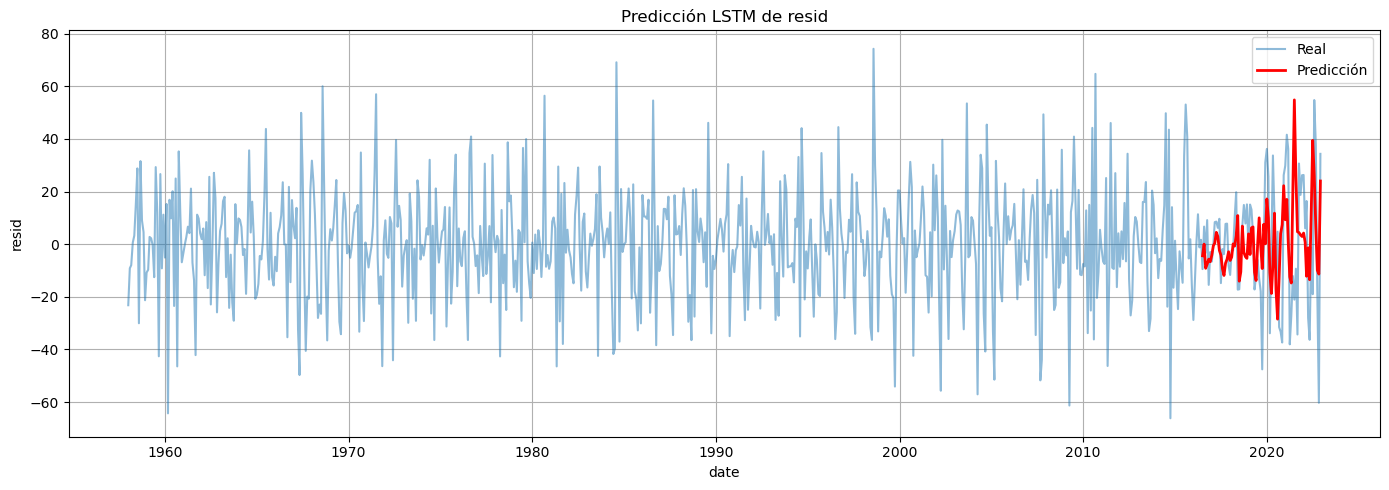

In [7]:
n_steps_r = 3

model_args_r = [
    {'layer': 'Input', 'units': (n_steps_r, 3), 'args': {}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_r = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mae'],
}

training_args_r = {
    'epochs': 150,
    'batch_size': 12,
    'validation_split': 0.2,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_r = train_model(
    target_column=target,
    date_col='date',
    train_column='resid',
    n_steps=n_steps_r,
    training_args=training_args_r,
    model_args=model_args_r,
    compile_args=compile_args_r
)

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
Epoch 1/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4761 - mse: 0.4718 - val_loss: 0.2842 - val_mse: 0.2798
Epoch 2/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1856 - mse: 0.1812 - val_loss: 0.1480 - val_mse: 0.1436
Epoch 3/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1191 - mse: 0.1146 - val_loss: 0.1671 - val_mse: 0.1626
Epoch 4/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0965 - mse: 0.0921 - val_loss: 0.1524 - val_mse: 0.1480
Epoch 5/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0916 - mse: 0.0871 - val_loss: 0.1496 - val_mse: 0.1452
Epoch 6/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0862 - mse: 0.0818 - val_loss: 0.1374 - val_mse: 0.1330
Epoch 7/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0842 - mse: 0.0798 - val_loss: 0.1034 - val_mse: 0.0990
Epoch 8/400
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

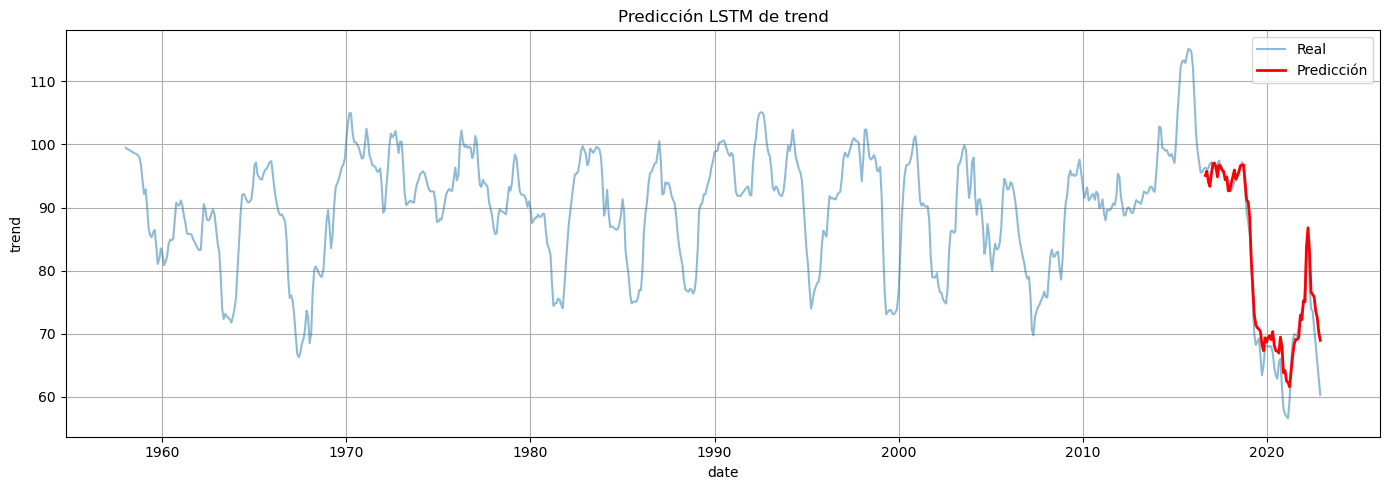

In [10]:
n_steps_t = 24
model_args_t = [
    {'layer': 'InputLayer', 'units': (n_steps_t, 3), 'args': {}},  # Un solo feature (trend)
    {'layer': 'LSTM', 'units': 128, 'args': {'return_sequences': True, 'use_cudnn':False, 'dropout': 0.0}},
    {'layer': 'LSTM', 'units': 64, 'args': {'return_sequences': False, 'use_cudnn':False, 'dropout': 0.0}},
    {'layer': 'Dense', 'units': 32, 'args': {'activation': 'relu', 'kernel_regularizer': l2(1e-4)}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_t = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_t = {
    'epochs': 400,
    'batch_size': 32,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=30, restore_best_weights=True)],
    'verbose': 1,
}

ad_t = train_model(
    target_column=target,
    date_col='date',
    train_column='trend',
    n_steps=n_steps_t,
    training_args=training_args_t,
    model_args=model_args_t,
    compile_args=compile_args_t
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (768, 12, 3)
y shape: (768,)
Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5683 - mse: 0.5683 - val_loss: 0.1448 - val_mse: 0.1448
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

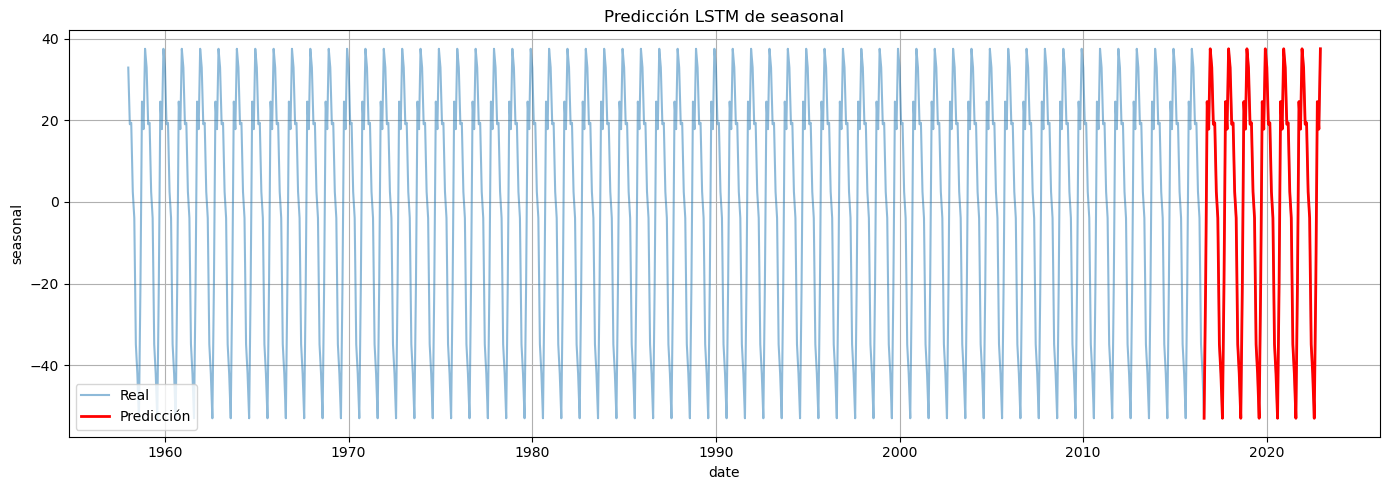

In [9]:
n_steps_s = 12

model_args_s = [
    {'layer': 'Input', 'units': (n_steps_s, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_s = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_s = {
    'epochs': 150,
    'batch_size': 16,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_s = train_model(
    target_column=target,
    date_col='date',
    train_column='seasonal',
    n_steps=n_steps_s,
    training_args=training_args_s,
    model_args=model_args_s,
    compile_args=compile_args_s
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8154 - mse: 0.8154 - val_loss: 0.6294 - val_mse: 0.6294
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5723 - mse: 0.5723 - val_loss: 0.5182 - val_mse: 0.5182
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4533 - mse: 0.4533 - val_loss: 0.4987 - val_mse: 0.4987
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4276 - mse: 0.4276 - val_loss: 0.4637 - val_mse: 0.4637
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4165 - mse: 0.4165 - val_loss: 0.4449 - val_mse: 0.4449
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4070 - mse: 0.4070 - val_loss: 0.4280 - val_mse: 0.4280
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3975 - mse: 0.3975 - val_loss: 0.4198 - val_mse: 0.4198
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

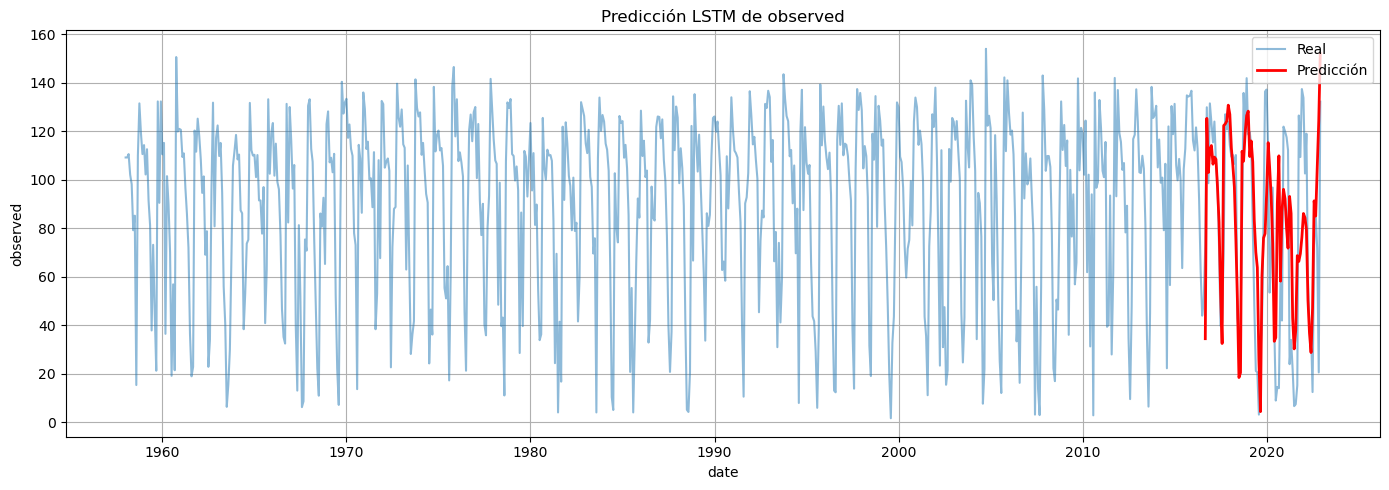

In [12]:
n_steps_o = 24

model_args_o = [
    {'layer': 'Input', 'units': (n_steps_o, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_o = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_o = {
    'epochs': 300,
    'batch_size': 24,
    'validation_split': 0.1,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_o = train_model(
    target_column=target,
    date_col='date',
    train_column='observed',
    n_steps=n_steps_o,
    training_args=training_args_o,
    model_args=model_args_o,
    compile_args=compile_args_o
)

c:\Users\aleja\anaconda3\envs\CGR_Analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\anaconda3\envs\CGR_Analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


%RMSE: 2528.68765394394
%MAE: 1955.488545478512


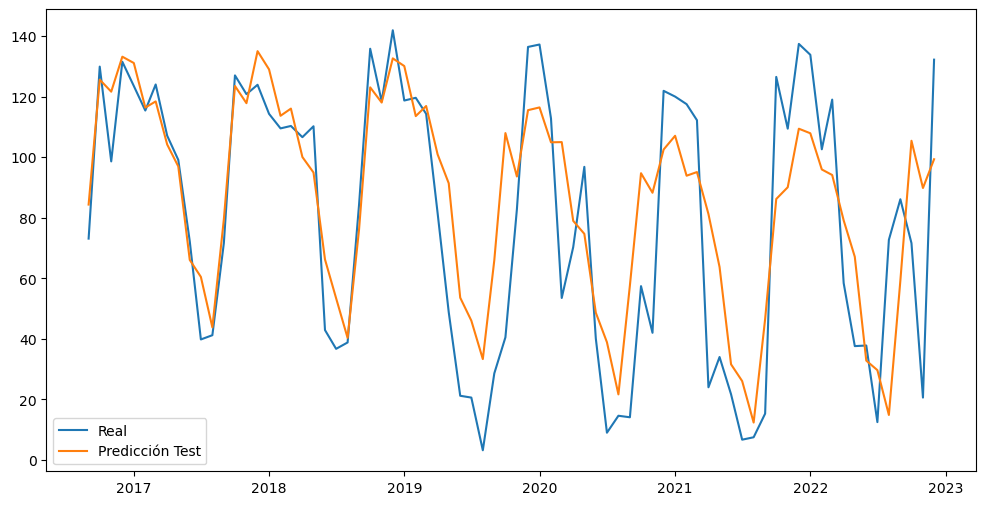

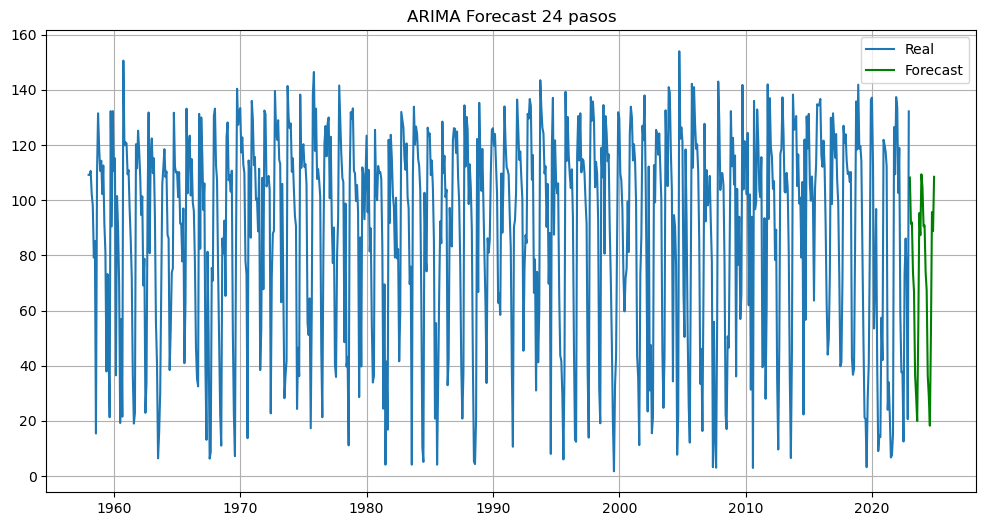

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
forecast_steps = 24
series = ad_o.df.set_index('date')['observed']

# División manual
train = series[:'2016-08']  # hasta diciembre 2020
test = series['2016-09':]   # desde enero 2021

# Ajustar solo con train
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

# Predecir en conjunto de prueba (in-sample)
start = test.index[0]
end = test.index[-1]
pred_test = result.predict(start=start, end=end)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(test, pred_test))
mae = mean_absolute_error(test, pred_test)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# (Opcional) Predecir pasos futuros después de test
# forecast = result.get_forecast(steps=24)
# pred_future = forecast.predicted_mean
# pred_ci = forecast.conf_int()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(pred_test.index, test, label='Real')
plt.plot(pred_test.index, pred_test, label='Predicción Test')
plt.legend()
plt.show()


forecast = result.get_forecast(steps=24)
pred_future = forecast.predicted_mean
pred_ci = forecast.conf_int()


plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Real')
plt.plot(pred_future.index, pred_future.values, label='Forecast', color='green')
plt.title(f"ARIMA Forecast {forecast_steps} pasos")
plt.legend()
plt.grid()
plt.show()

c:\Users\aleja\anaconda3\envs\CGR_Analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\anaconda3\envs\CGR_Analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aleja\anaconda3\envs\CGR_Analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


%RMSE: 3330.3111020954248
%MAE: 2679.0462037743696


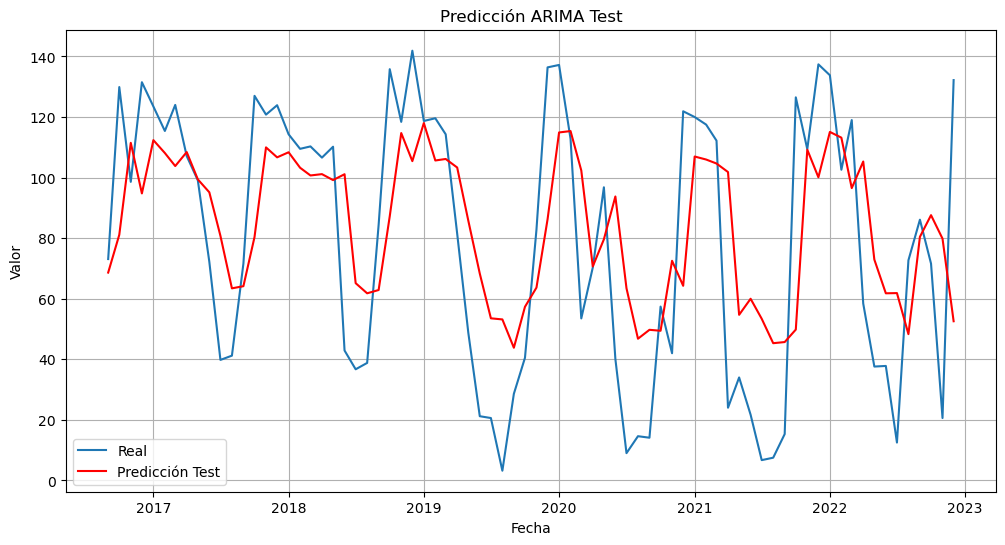

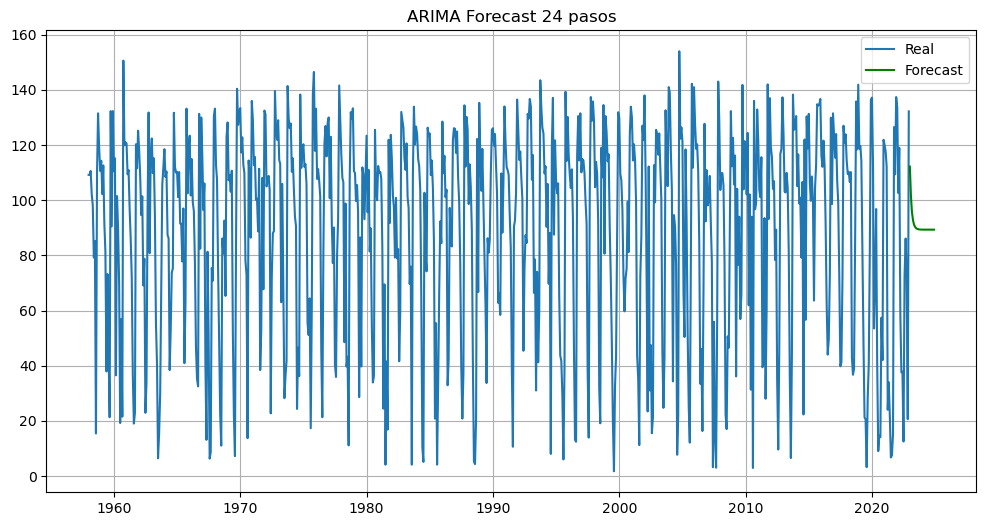

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Tu serie mensual
series = ad_o.df.set_index('date')['observed']

# División manual en train/test
train = series[:'2016-08']
test = series['2016-09':]

# Ajustar modelo ARIMA solo con train
# order = (p,d,q) -> ajusta según ACF/PACF o prueba heurística
model = ARIMA(series, order=(1,1,1))
result = model.fit()

# Predicción en el conjunto de prueba
pred_test = result.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Métricas
rmse = np.sqrt(mean_squared_error(test, pred_test))
mae = mean_absolute_error(test, pred_test)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Graficar real vs predicción test
plt.figure(figsize=(12,6))
plt.plot(pred_test.index, test, label='Real')
plt.plot(pred_test.index, pred_test, label='Predicción Test', color='red')
plt.title("Predicción ARIMA Test")
plt.xlabel("Fecha")
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# Predicción de pasos futuros (out-of-sample)
forecast_steps = 24
forecast = result.get_forecast(steps=forecast_steps)
pred_future = forecast.predicted_mean
pred_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Real')
plt.plot(pred_future.index, pred_future.values, label='Forecast', color='green')
plt.title(f"ARIMA Forecast {forecast_steps} pasos")
plt.legend()
plt.grid()
plt.show()


%RMSE: 8962.985180273832
%MAE: 8545.629090294604


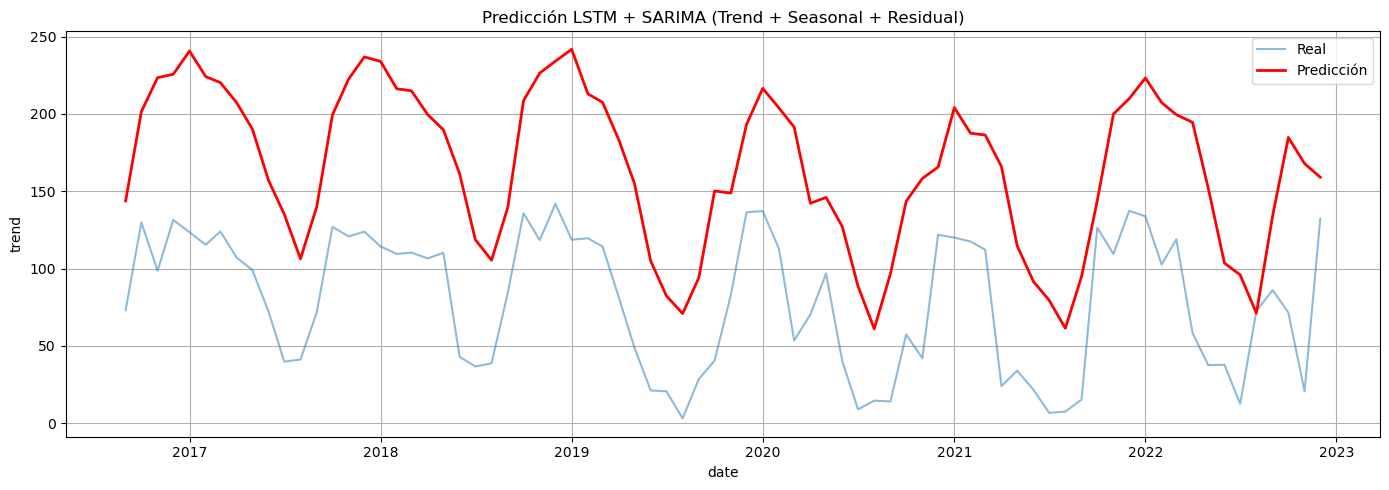

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Tomar la longitud mínima entre los arrays para que coincidan
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled),
    len(pred_test.values)
)

# Convertir todo a 1D
r_true = ad_r._true_rescaled[-min_len:].flatten()
t_true = ad_t._true_rescaled[-min_len:].flatten()
s_true = ad_s._true_rescaled[-min_len:].flatten()

s_pred = ad_s._pred_rescaled[-min_len:].flatten()
t_pred = ad_t._pred_rescaled[-min_len:].flatten()
r_pred = pred_test.values[-min_len:].flatten()  # SARIMA trend o residual según tu modelo

# Sumar elemento a elemento
true_rescaled = r_true + t_true + s_true
pred_rescaled = r_pred + t_pred + s_pred

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Fechas
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM + SARIMA (Trend + Seasonal + Residual)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

%RMSE: 2319.1116566650708
%MAE: 1781.9048379596913


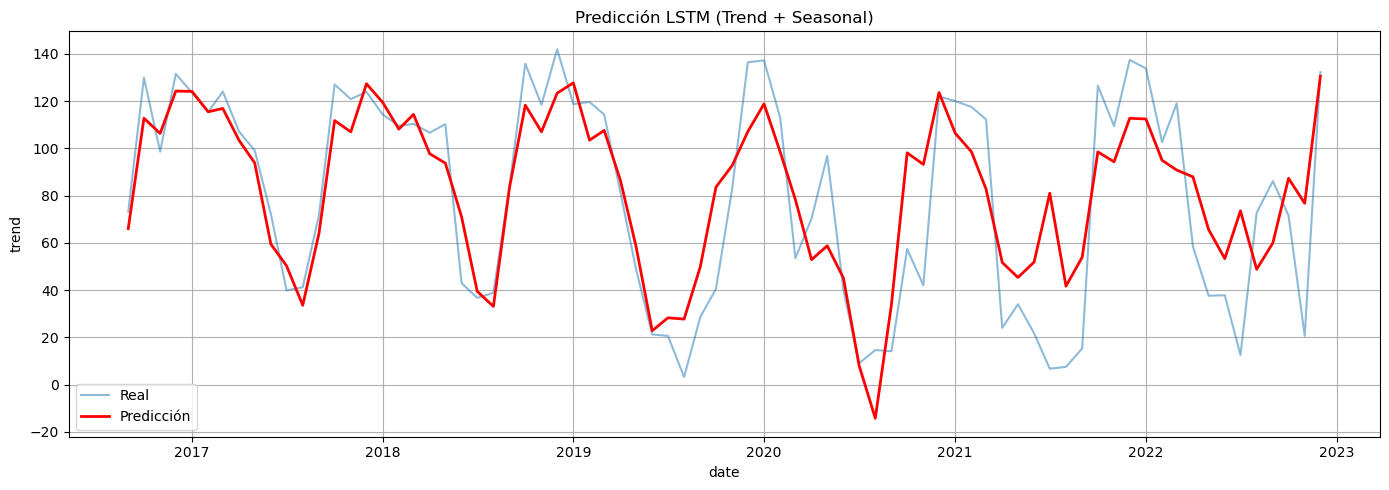

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encontrar la longitud mínima entre las predicciones verdaderas de los modelos
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled)
)

# Recortar las verdaderas y predichas para que tengan la misma longitud (solo trend + seasonal)
true_rescaled = (
    ad_t._true_rescaled[-min_len:]
    + ad_s._true_rescaled[-min_len:]
    + ad_r._true_rescaled[-min_len:]
)

pred_rescaled = (
    ad_t._pred_rescaled[-min_len:]
    + ad_s._pred_rescaled[-min_len:]
    + ad_r._pred_rescaled[-min_len:]
)

# Aplanar los arrays para matplotlib
true_rescaled = true_rescaled.flatten()
pred_rescaled = pred_rescaled.flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Usar las fechas del modelo trend para el eje x, recortadas al mismo rango
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM (Trend + Seasonal)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


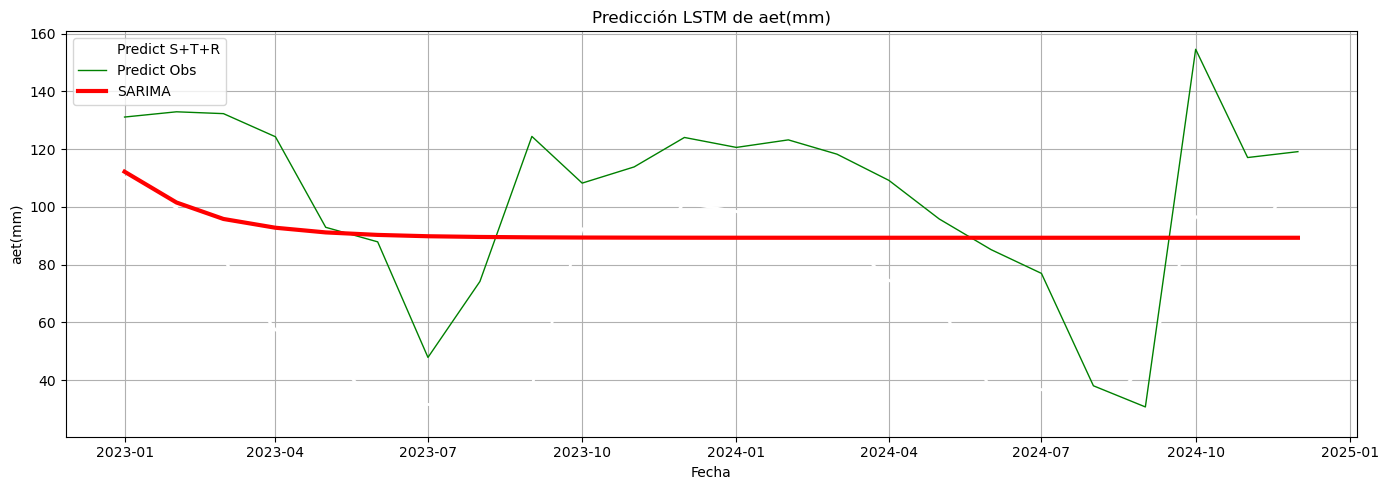

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
def build_dates(year):
    return [f'{year}{month}01' if month >= 10 else f'{year}0{month}01' for month in range(1, 13)]
dates_input = build_dates(2023)
dates_input = dates_input + build_dates(2024)
predicts = []
predicts1 = []
for date in dates_input:
    _predict = ad_r.predict_for_date(date)
    _predict += ad_t.predict_for_date(date)
    _predict += ad_s.predict_for_date(date)
    predicts.append(_predict)

    _predict = ad_o.predict_for_date(date)
    predicts1.append(_predict)

forecast = result.get_forecast(steps=24)
pred_future = forecast.predicted_mean.values
pred_ci = forecast.conf_int()
plt.figure(figsize=(14,5))
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts, label="Predict S+T+R", color='white', linewidth=2)
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts1, label="Predict Obs", color='green', linewidth=1)
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), pred_future, label="SARIMA", color='red', linewidth=3)
#plt.plot(ad_r.df['date'], ad_r.df['observed'], label="Real", color="red", linewidth=2)
plt.title("Predicción LSTM de " + target)
plt.xlabel("Fecha")
plt.ylabel(target)
plt.legend()
plt.grid()
plt.tight_layout()